## Import modules

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable
import time
# import torchvision.models as models
import os
from torchvision import transforms
import shutil

## Load dataset

In [155]:
# CIFAR10 Test dataset and dataloader declaration
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load model

In [142]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.conv1 = self._make_layer(3, 64, maxpool=True)
        self.conv2 = self._make_layer(64, 128, maxpool=True)
        self.conv3 = self._make_layer(128, 256, maxpool=False)
        self.conv4 = self._make_layer(256, 256, maxpool=True)
        self.conv5 = self._make_layer(256, 512, maxpool=False)
        self.conv6 = self._make_layer(512, 512, maxpool=True)
        self.conv7 = self._make_layer(512, 512, maxpool=False)
        self.conv8 = self._make_layer(512, 512, maxpool=True)
        self.avgpool = nn.AvgPool2d(kernel_size=1)
        self.classifier = nn.Linear(512, 10)
        
    def _make_layer(self, in_dim, out_dim, maxpool=False):
        if maxpool:
            return nn.Sequential(
                        nn.Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
                        nn.BatchNorm2d(out_dim),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            return nn.Sequential(
                        nn.Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
                        nn.BatchNorm2d(out_dim),
                        nn.ReLU(inplace=True))
        
    def forward(self, x):
        o1 = self.conv1(x)
        o2 = self.conv2(o1)
        o3 = self.conv3(o2) 
        o4 = self.conv4(o3)
        o5 = self.conv5(o4)
        o6 = self.conv6(o5)
        o7 = self.conv7(o6)
        o8 = self.conv8(o7)
        
        o9 = self.avgpool(o8)
        o9 = o9.view(-1, torch.prod(torch.tensor(o9.shape)[1:]))
        
        out = self.classifier(o9)
        return out, (o1, o2, o3, o4, o5, o6, o7, o8, o9)

In [143]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = VGG11()
model.to(device)

CUDA Available:  True


VGG11(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [144]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

## Train 

In [145]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=30)
criterion = nn.CrossEntropyLoss()

In [146]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [147]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    total = 0
    correct = 0
    
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input = input.to(device)
        target_var = target

        # compute output
        output, _ = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # measure accuracy and record loss
        _, predicted = output.max(1)
        losses.update(loss.item(), input.size(0))
        total += target.size(0)
        correct += predicted.eq(target).sum().item()


        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc:.3f}'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, acc=correct/total))


In [148]:
def test(test_loader, model, epoch):
    """
        Run one train epoch
    """
    total = 0
    correct = 0
    
    # switch to train mode
    model.eval()

    for i, (input, target) in enumerate(test_loader):

        target = target.to(device)
        input = input.to(device)

        # compute output
        with torch.no_grad():
            output, _ = model(input)

        # measure accuracy and record loss
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()


    print('Epoch: [{0}]\t'
          'Accuracy {acc:.3f}'.format(
           epoch, acc=correct/total))

    return correct/total

In [149]:
def save_checkpoint(state,filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

In [150]:
global best_prec1
best_prec1 = 0

for epoch in range(50):

    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(trainloader, model, criterion, optimizer, epoch)
    perc = test(testloader, model, epoch)
    
    lr_scheduler.step()

    if perc > best_prec1:

        save_checkpoint({
            'state_dict': model.state_dict()
        },  filename=os.path.join('./checkpoints/', 'model.th'))
        
        best_prec1 = perc

current lr 1.00000e-02
Epoch: [0][0/391]	Time 0.161 (0.161)	Data 0.143 (0.143)	Loss 2.5255 (2.5255)	Accuracy 0.062
Epoch: [0][50/391]	Time 0.016 (0.019)	Data 0.002 (0.005)	Loss 1.3967 (1.6876)	Accuracy 0.375
Epoch: [0][100/391]	Time 0.016 (0.017)	Data 0.002 (0.003)	Loss 1.4328 (1.5283)	Accuracy 0.437
Epoch: [0][150/391]	Time 0.013 (0.016)	Data 0.001 (0.003)	Loss 1.3146 (1.4467)	Accuracy 0.466
Epoch: [0][200/391]	Time 0.013 (0.015)	Data 0.001 (0.003)	Loss 1.1456 (1.3883)	Accuracy 0.489
Epoch: [0][250/391]	Time 0.014 (0.015)	Data 0.002 (0.002)	Loss 1.2047 (1.3385)	Accuracy 0.509
Epoch: [0][300/391]	Time 0.013 (0.015)	Data 0.002 (0.002)	Loss 1.0470 (1.2954)	Accuracy 0.527
Epoch: [0][350/391]	Time 0.015 (0.015)	Data 0.003 (0.002)	Loss 1.0293 (1.2564)	Accuracy 0.542
Epoch: [0]	Accuracy 0.531
current lr 1.00000e-02
Epoch: [1][0/391]	Time 0.159 (0.159)	Data 0.139 (0.139)	Loss 0.9369 (0.9369)	Accuracy 0.633
Epoch: [1][50/391]	Time 0.013 (0.017)	Data 0.002 (0.005)	Loss 0.8636 (0.8480)	Accuracy 

Epoch: [10][150/391]	Time 0.013 (0.015)	Data 0.002 (0.003)	Loss 0.0016 (0.0016)	Accuracy 1.000
Epoch: [10][200/391]	Time 0.013 (0.015)	Data 0.001 (0.002)	Loss 0.0011 (0.0016)	Accuracy 1.000
Epoch: [10][250/391]	Time 0.015 (0.014)	Data 0.004 (0.002)	Loss 0.0010 (0.0015)	Accuracy 1.000
Epoch: [10][300/391]	Time 0.013 (0.014)	Data 0.001 (0.002)	Loss 0.0016 (0.0015)	Accuracy 1.000
Epoch: [10][350/391]	Time 0.016 (0.015)	Data 0.002 (0.002)	Loss 0.0017 (0.0015)	Accuracy 1.000
Epoch: [10]	Accuracy 0.786
current lr 1.00000e-02
Epoch: [11][0/391]	Time 0.168 (0.168)	Data 0.147 (0.147)	Loss 0.0018 (0.0018)	Accuracy 1.000
Epoch: [11][50/391]	Time 0.016 (0.019)	Data 0.003 (0.005)	Loss 0.0007 (0.0012)	Accuracy 1.000
Epoch: [11][100/391]	Time 0.016 (0.017)	Data 0.002 (0.004)	Loss 0.0014 (0.0011)	Accuracy 1.000
Epoch: [11][150/391]	Time 0.017 (0.016)	Data 0.004 (0.003)	Loss 0.0012 (0.0011)	Accuracy 1.000
Epoch: [11][200/391]	Time 0.014 (0.016)	Data 0.002 (0.003)	Loss 0.0009 (0.0010)	Accuracy 1.000
Epo

KeyboardInterrupt: 

## Attack function

In [151]:
model.load_state_dict(torch.load('./checkpoints/model.th')['state_dict'])
model.eval()

VGG11(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [152]:
def adv_attack(image, epsilon, data_grad, attack_method):
    assert attack_method in ['fgsm', 'stepll'] 
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = torch.sign(data_grad)
    
    # Create the perturbed image by adjusting each pixel of the input image
    if attack_method == 'fgsm':
        perturbed_image = image + epsilon*sign_data_grad
    else:
        perturbed_image = image - epsilon*sign_data_grad
        
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [160]:
def test(model, device, dataloader, criterion, attack_method, epsilon):
    assert attack_method in ['fgsm', 'stepll'] 
    
    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []
    ct_save = 0
    
    # Loop over all examples in test set
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output, _ = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        if init_pred.item() != target.item(): # initially was incorrect --> no need to generate adversary
            continue
        
        if attack_method == 'fgsm':
            loss = criterion(output, target) # loss for ground-truth class
        else:
            ll = output.min(1, keepdim=True)[1][0]
            loss = criterion(output, ll)  # Loss for least-likely class
            
        # Back propogation
        model.zero_grad()
        loss.backward()

        # Collect data_grad
        data_grad = data.grad.data

        # Call Attack
        perturbed_data = adv_attack(data, epsilon, data_grad, attack_method)
        
        # Re-classify the perturbed image
        model.eval()
        with torch.no_grad():
            output,_ = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1 # still correct
            
        else: # attack is successful
            if ct_save < 100:
                os.makedirs('./data/normal', exist_ok=True)
                os.makedirs('./data/adversarial', exist_ok=True)
               # Save the original instance
                torch.save((data.detach().cpu(), init_pred.detach().cpu()), './data/normal/{}_{}.pt'.format(attack_method, ct_save))
                # Save the adversarial example
                torch.save((perturbed_data.detach().cpu(), final_pred.detach().cpu()), './data/adversarial/{}_{}.pt'.format(attack_method, ct_save))
            ct_save += 1
            
        # Special case for saving 0 epsilon examples
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(dataloader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [161]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
attack_method = 'fgsm'

# for eps in epsilons:
#     acc, ex = test(model, device, testloader, criterion, attack_method, eps)
#     accuracies.append(acc)
#     examples.append(ex)

shutil.rmtree('./data/normal/')
shutil.rmtree('./data/adversarial/')
acc, ex = test(model, device, testloader, criterion, attack_method, epsilon=0.05)

Epsilon: 0.05	Test Accuracy = 193 / 7867 = 0.0193


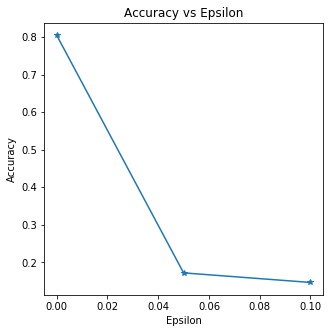

In [170]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:len(accuracies)], accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [175]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
attack_method = 'stepll'

for eps in epsilons:
    acc, ex = test(model, device, testloader, criterion, attack_method, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8046 / 8046 = 0.8046
Epsilon: 0.05	Test Accuracy = 2259 / 8046 = 0.2259
Epsilon: 0.1	Test Accuracy = 1691 / 8046 = 0.1691


KeyboardInterrupt: 

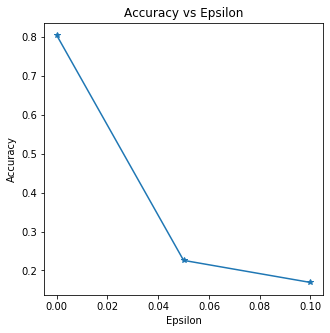

In [176]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:len(accuracies)], accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

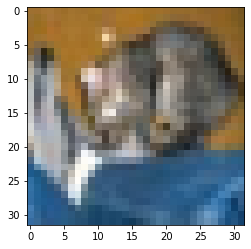

In [185]:
plt.imshow(testset[0][0].permute(1,2,0))

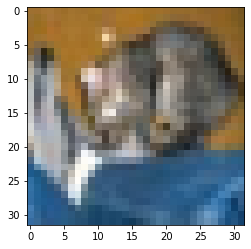

In [182]:
plt.imshow(np.transpose(examples[0][0][-1], (1,2,0)))